In [14]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


### 1. Instructions:

In order to run the code properly, please follow this recommended procedure:

1)	Click on "Cell" and then click on "Run All".

2)	Select 'Test Type' parameter (i.e., Cyclic or Monotonic). The Available Test Cases corresponding to this Test Type will be shown on the DropDown Manu below. The description details of these available test cases will be shown in the text area to the right of the test case selection area. 

3) Select 'Stage' parameter (i.e., Consolidation or Shear). 

4) Select 'Test Case(s)' and start plotting. Click on a particular test case (e.g., 'SW1') to start plotting. To plot **multiple** Test Cases simultaneously, strike **'Ctrl'** key (or **'Command'** key for Mac) and hold, then start selecting multiple test cases. As one add or drop test cases, the plot area will be dynamically updated. 

5) Finally, one can export the produced figures into PDF. The file name needs to be specified by the user by typing in the 'Fig. Name' text box and end the name with '.pdf'. 

Note: DSS = 'Direct Simple Shear'

In [15]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [16]:
%matplotlib notebook
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import numpy as np
import pandas as pd
from ipywidgets import *
from IPython.display import display
from IPython.display import clear_output
from matplotlib import rc
from matplotlib import ticker
from scipy.signal import find_peaks_cwt
from scipy import optimize
from scipy.optimize import leastsq
import os

font = {'color':  'black',
        'weight': 'normal',
        'size': 12}

layout100 = Layout(display='flex',flex_flow='row', border='solid 1px',align_items='stretch',width='100%')
matplotlib.rcParams.update({'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

In [17]:
# Init Widget Elements 
radio_btn_test_type = widgets.RadioButtons(options=['Cyclic','Monotonic'],
                             description='DSS Test Type',variable=[True,False])

seclect_multi_test = widgets.SelectMultiple(description="Test Cases",options= [])

ta = Textarea(value= "", disabled=True,
              layout=layout100,
              description="Details of Test Cases")

btn_save_figure = widgets.Button(description='Save Figure')
text_fig_name = widgets.Text(description="Fig. Name")


slider_param = FloatSlider(min=1, max=25, step=0.5, description = "Strain% Adjustor", 
                              continuous_update = False)
slider_param.value = 3

In [18]:
###### Init input parameters #########
# All params defined here are global variables and are assumed to be visible throughout the notebook 
file_description = 'Description.csv'
#############################################################################################
info = pd.read_csv(file_description,delimiter=',',dtype='str',skiprows=13)
info = info.set_index('HEADING')
dssg = info.loc[:'GROUP']
dsst = info.loc['HEADING':]
dsst_col = dsst.loc['HEADING'].tolist()
dsst.columns = dsst_col
dsst = dsst[1:]
#############################################################################################

dir_root = os.getcwd()
dir_root_cyclic = dir_root + "/Cyclic/"
dir_root_monotonic = dir_root + "/Monotonic/"
test_dir = dir_root_monotonic

In [19]:
def on_button_save_fig_clicked(b):
    '''
    callback function for Saving Output Figures
    '''
    pdf = matplotlib.backends.backend_pdf.PdfPages(text_fig_name.value)
    pdf.savefig(b.fig_shear)        
    pdf.close()
    print('Figure Exported')
# add action to be performed on click
btn_save_figure.on_click(on_button_save_fig_clicked)


def get_test_dir(test_type):
    '''
    Get test dir according to chosen test type
    '''
    if test_type == "Cyclic":
        test_dir = dir_root_cyclic
    elif test_type == "Monotonic":
        test_dir = dir_root_monotonic  
    return test_dir

In [20]:
def get_descriptions(dssg, test, test_type):
    '''
    Create description string based on chosen test cases and test types
    
    Input Parameters:
    test: a list of test cases strings (e.g., ["FW1", "FW2"])
    test_type: Monotonic or Cyclic
    
    Current fescription format for each test case is: 
    SW3: Salt water mix of 90% silt and 10% bentonite clay
    
    
    dependency: require 'dssg'
    '''
    
    if test_type == "Cyclic":
        descriptions = ""
    elif test_type == "Monotonic":
        descriptions = ""
        for test_case in test: 
            this_row = dssg[dssg['SPEC_REF']==test_case]

            if len(this_row) != 0:
                new_description_to_append =  test_case + ": " + \
                    str(this_row["DSSG_DESC"].values[0]) + "\n"
            else:
                new_description_to_append = test_case + ": None" + "\n"
            descriptions = descriptions + new_description_to_append            
    return descriptions

############# get detailed descriptions ##################################
def describe(test_type, test_name, description_g, description_t, IVRt):
    if (description_t['DSST_IVS'].tolist() == []):
        print("None")
        return 

    if test_type != "Cyclic":
        print(test_name +' DESCRIPTION: \n'+ description_g['DSSG_DESC'].tolist()[0])
        print('And '+description_t['DSST_DESC'].tolist()[0])
        print('Plastic Limit(PL) = ' + description_g['DSSG_PL'].tolist()[0]+
            ';\nLiquid Limit(LL) = ' + description_g['DSSG_LL'].tolist()[0]+
            ';\nPlastic Index(PI) = ' + description_g['DSSG_PI'].tolist()[0]+
            ';\nMax. past pressure Sigma_p = '+ description_g['DSSG_SIGP'].tolist()[0]+'kPa;'
             )
        if IVRt == 0.9:
            print('Initial Void Ratio assumed to be 0.9;\n')
        else:
            print('\n')
    else:
        print('No description on test yet.\n')
 

In [21]:
import statsmodels.api as sm
def fit_csl(sigma_v, e_c, axes):
    '''
    x is in log(sigma_v)
    y is e_c
    fit a linear regression line
    
    y =  Gamma + Lambda * x
    '''
    # transform to log(sigma_v)
    logx = np.log(sigma_v)
    X = logx
    y = e_c #dependent variable
    
    # y = a  + b * x
    X = sm.add_constant(X)
    
    # construct a model, which is an ordinary least square model (OLS)
    model = sm.OLS(y,X)
    # call fit function to solve the model, the results will contian 
    # - params, which is 2-by-1 array, first element is a (i.e, Gamma) and second element is b (i.e., Lambda)
    # - fittedvalues: fitted y (y_hat)
    # - error = y -y_hat (a.k.a residual)
    # - t-stats (2-by-1)
    
    results = model.fit()   
    
    Gamma = results.params[0]
    Lambda = results.params[1]
    
    
    x_new = np.linspace(np.min(logx*0.8), np.max(logx*1.2),100)
    y_new = Gamma + Lambda * x_new
    #axes.semilogx(x_new, powerlaw(x_new, a, b))

    axes.plot(x_new, y_new)
    
    return (Gamma,Lambda, results.rsquared)

In [22]:
def fit_powerlaw(x, y, axes):
    '''
    Given x and y, this function solves for S and m.
    '''
    yerr = [i * 0.2 for i in y]
    logx = np.log10(x)
    logy = np.log10(y)

    yerr = np.asarray(yerr)
    y = np.asarray(y)
    x = np.asarray(x)
    logyerr = yerr / y

    fitfunc = lambda p, x: p[0] + p[1] * x
    errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err

    pinit = [1.0, -1.0]
    out = optimize.leastsq(errfunc, pinit,
                           args=(logx, logy, logyerr), full_output=1)

    pfinal = out[0]
    covar = out[1]
    b = pfinal[1]
    a = 10.0**pfinal[0]

    powerlaw = lambda x, a, b: a * (x**b)
    
    x_new = np.linspace(np.min(x*0.8), np.max(x*1.2),100)
    axes.semilogx(x_new, powerlaw(x_new, a, b))
    
    return (a,b)

In [23]:
def plot_CSR(time, shear_strain, axes, peak_avg, period, initial_vertical_stress,label_CSR):
    
    time_def_percent = time[-1]
    CSR = round(float(peak_avg/initial_vertical_stress),4)
    Number_of_Cycle = round(float(time_def_percent/period),1)    
                
    axes.semilogx(Number_of_Cycle, CSR, 'o', label = label_CSR)
    axes.set_xlabel('Number of Cycle, N (logscale)', fontdict=font)
    axes.set_ylabel('Cyclic Stress Ratio, CSR', fontdict=font)
    axes.set_title('CSR Plot', fontdict=font)
    axes.grid(True, which='both')
    axes.tick_params(axis='x', which='minor')
    axes.legend(bbox_to_anchor=(1, 1),prop={'size':8}) 
    
    print (label_CSR + '; CSR = '+str(CSR)+'; Number of Cycle: '+str(Number_of_Cycle))
    return (Number_of_Cycle, CSR)

In [24]:
def strength_normalize(OCR, initial_vertical_stress, shear_strain, shear_stress, axes, strain_limit, f):

    diff_arr = abs(abs(shear_strain) - strain_limit)
    index_min = diff_arr.argmin()
    residual = shear_stress[index_min]
    Su_sigma = residual/initial_vertical_stress

    axes.semilogx(OCR,Su_sigma,'o')
    axes.set_xlim([1, 10])
    axes.set_title('Strength Normalization Plot')
    axes.set_ylabel(r'$\mathrm{\frac{S_u}{\sigma_v}}$',fontsize=18)
    axes.set_xlabel('OCR (logscale)')
    axes.set_title('Strength Normalization Plot', fontdict=font)
    axes.tick_params(axis='y', which='minor')
    axes.grid(True, which="both")
    f.tight_layout()
    return(OCR,Su_sigma)
  

In [25]:
def plot_all(test_type, seclect_multi_test):
     
    test_chose = list(seclect_multi_test)
    test_dir = get_test_dir(test_type)
    L = len(test_chose)
    
    # for plotting later 
    Number_of_Cycle_arr = np.zeros(L)*np.nan 
    CSR_arr = np.zeros(L)*np.nan
    Void_Ratio_arrf = np.zeros(L)*np.nan
    Vertical_stress_arrf = np.zeros(L)*np.nan
    OCR_arr = np.zeros(L)*np.nan
    Su_arr = np.zeros(L)*np.nan
            
    if L > 0:
        f, axes = plt.subplots(1,2,figsize=(10,5))
        btn_save_figure.fig_shear = f

        for i in range(0,L):
            path = test_dir + test_chose[i]+'/'+ 'Shear.txt'
            data = np.genfromtxt(path, delimiter=',')

            time_raw = data[2: ,0] - data[2,0]
            shear_stress = data[2: ,17]
            shear_strain = data[2: ,14] 
            
            #define plotting range according to strain limit value
            strain_limit = slider_param.value
            is_abs_above_limit = abs(shear_strain) > strain_limit
            index_limit = np.where(is_abs_above_limit)[0][0]
            index_limit2 = index_limit+1

            if test_type == 'Cyclic':
                lab = test_chose[i]
                driving = data[2:,22]
                start_index = np.where(driving>0)[0][0]
                driving = driving[start_index:]
                pwp = data[start_index:index_limit2,20]
                vertical_stress = data[start_index:index_limit2,18]
                initial_vertical_stress = vertical_stress[0]
                Ru = pwp/initial_vertical_stress
                void_ratio = 0*time_raw
                
                time = time_raw[start_index:index_limit2]-time_raw[start_index]
                shear_strain = shear_strain[start_index:index_limit2]
                shear_stress = shear_stress[start_index:index_limit2]

                for n in range(1,len(driving)):
                    if (driving[n]>driving[n-1]) & (driving[n]>driving[n+1]):
                        first_peak=n
                        peak1=shear_stress[first_peak]
                        peak2=shear_stress[first_peak*3]
                        period = (time[n+1])*4
                        break
                peak_avg =(abs(peak1)+abs(peak2))/2
                cycle_all = time/period

                lab_csr = lab +'; strain:'+ str(slider_param.value)+'%'
                (Number_of_Cycle, CSR) = plot_CSR(time, shear_strain,axes[0], peak_avg, period, 
                                                initial_vertical_stress, lab_csr)
                f.tight_layout()
                Number_of_Cycle_arr[i] =Number_of_Cycle
                CSR_arr[i] =CSR
                axes[1].axis('off')
                
            else:
                max_strain = max(shear_strain)
                diff_arr3 = abs(abs(shear_strain) - max_strain)
                index_min3 = diff_arr3.argmin()

                shear_strain = data[2:index_min3,14]
                time = data[2:index_min3,0] - data[2,0]
                pwp = data[2:index_min3,20]
                shear_stress = data[2:index_min3,17]
                vertical_stress = data[2:index_min3,18]
                FVSt = vertical_stress[-1]

                initial_vertical_stress = vertical_stress[0] 
                condition = (dsst['SPEC_REF']==test_chose[i])&(dsst['DSST_FSET']=='Shear.txt')
                description_g = dssg[(dssg['SPEC_REF']==test_chose[i])]
                description_t = dsst[condition]
                #initial and final void ratio:
                IVRt = float(description_t['DSST_IVR'].tolist()[0])
                FVRt = float(description_t['DSST_FVR'].tolist()[0])
                OCR = str(int(description_t['DSST_IOCR'].tolist()[0]))        
                lab = test_chose[i] + ';OCR='+OCR

                describe(test_type=test_type, test_name=test_chose[i], 
                         description_g=description_g, description_t=description_t, 
                         IVRt=IVRt)    
                
                Void_Ratio_arrf[i] = FVRt
                Vertical_stress_arrf[i] = FVSt
                # x is in natural log scale
                axes[0].plot(np.log(FVSt), FVRt, '^', label=test_chose[i]+'final')
                axes[0].set_ylim([0.7,0.85])
                axes[0].set_xlabel('Vertical Stress(kPa) (logscale)', fontdict=font)
                axes[0].set_ylabel('Void Ratio, e', fontdict=font)
                axes[0].set_title('Critical State Line', fontdict=font)
                axes[0].legend(bbox_to_anchor=(1, 1),prop={'size':8})
                axes[0].grid(True,which='both')
                f.tight_layout()
                
                (OCR, Su_sigma) = strength_normalize(OCR, initial_vertical_stress, shear_strain, shear_stress, 
                                                     axes[1], strain_limit, f)
                OCR_arr[i] =OCR
                Su_arr[i] =Su_sigma

                
    if L >= 2 and test_type == "Cyclic":
        (a,b)=fit_powerlaw(Number_of_Cycle_arr, CSR_arr, axes[0])
        axes[0].text(0.5, 0.5,r'${CRR = %.2f*N^{%.2f}}$' % (a,b),
              transform=axes[0].transAxes)  
        
    elif L >= 2 and test_type == "Monotonic":
        ################ x=vertical_stress; y=void_ratio ####################
        (gamma, labda, rsquared) = fit_csl(Vertical_stress_arrf, Void_Ratio_arrf, axes[0])
        axes[0].text(0.25,0.5,r'$CSL: e_c=%.2f%.2f*log(\sigma_v)$' %(gamma, labda),fontsize=12, 
                    transform=axes[0].transAxes)
        #axes[0].text(0.25,0.45,r'$R-Squared= %4.2f$' %(rsquared),fontsize=12, 
        #            transform=axes[0].transAxes)
        (S,m)=fit_powerlaw(OCR_arr, Su_arr, axes[1])
        axes[1].text(0.5,0.5,r'$\frac{S_u}{\sigma_v}=%4.2f * OCR^{%4.2f}$' %(S, m),fontsize=12, 
                     horizontalalignment='center',verticalalignment='center', transform=axes[1].transAxes)
        f.tight_layout()
        #pd.options.display.max_colwidth = 100        

<IPython.core.display.Javascript object>


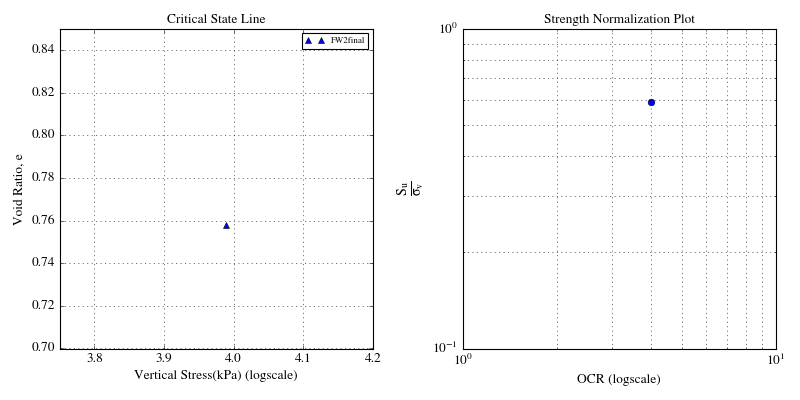

FW2 DESCRIPTION: 
Fresh water mix of 95% silt and 5% bentonite clay
And monotonically shear the specimen to 20% shear strain in 5 minutes
Plastic Limit(PL) = 27;
Liquid Limit(LL) = 36;
Plastic Index(PI) = 9;
Max. past pressure Sigma_p = 20kPa;




In [26]:
def on_test_type_change(*args):
    ##### Update Test Cases#####
    # Get all files in the current directory
    files = os.listdir(dir_root)
    test_type = radio_btn_test_type.value
    # get test dir per test type
    test_dir = get_test_dir(test_type)
        
    files = os.listdir(test_dir)
    test = [f for f in files if ((f.startswith("SW")) | (f.startswith("FW")))]    
        
    seclect_multi_test.options = test
    
    ##### Update Text Area ########
    ta.value = get_descriptions(dssg = dssg, 
                                test = seclect_multi_test.options, test_type= radio_btn_test_type.value)
    
    
def update_plot(*args):
    clear_output()
    plot_all(test_type = radio_btn_test_type.value, seclect_multi_test = seclect_multi_test.value)
    
def on_slider_change(*args):
    if (radio_btn_test_type.value == "Cyclic"):        
        update_plot(*args)
    if (radio_btn_test_type.value == "Monotonic"):  
        update_plot(*args)

files = os.listdir(get_test_dir(radio_btn_test_type.value))
test = [f for f in files if ((f.startswith("SW")) | (f.startswith("FW")))]

seclect_multi_test.options = test
# add test_type observer
radio_btn_test_type.observe(on_test_type_change, names="value")
seclect_multi_test.observe(update_plot, names="value")
# update plot when slider changes and filter is matched 
slider_param.observe(on_slider_change, names="value")

hbox_param_major = widgets.HBox([radio_btn_test_type, slider_param], 
    layout = Layout(display='flex',flex_flow='row', border='solid 1px',align_items='stretch', width='100%',height="50%"))

vbox_test = widgets.VBox([seclect_multi_test], 
    layout = Layout(overflow_y = "scroll", display='flex',flex_flow='row', border='solid 1px',
                    align_items='stretch', width="50%")) 
hbox_main =widgets.HBox([vbox_test, ta],
    layout = Layout(display='flex',flex_flow='row', border='solid 1px',align_items='stretch', width='100%',height="70%"))

hbox_save_fig = widgets.HBox([text_fig_name, btn_save_figure],
          layout = Layout(display='flex',flex_flow='row', border='solid 1px',align_items='stretch', width='100%',height="30%"))                   

display(hbox_param_major)
display(hbox_main)
display(hbox_save_fig)